In [ ]:
from src.pipeline import VSFStableDiffusion3Pipeline

In [ ]:
import torch
pipe = VSFStableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-large-turbo",
    torch_dtype=torch.bfloat16,
).to("cuda")

In [ ]:
import torch
from nag import NAGStableDiffusion3Pipeline

pipe_nag = NAGStableDiffusion3Pipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    text_encoder_2=pipe.text_encoder_2,
    text_encoder_3=pipe.text_encoder_3,
    tokenizer=pipe.tokenizer,
    tokenizer_2=pipe.tokenizer_2,
    tokenizer_3=pipe.tokenizer_3,
    scheduler=pipe.scheduler,
    transformer=pipe.transformer,
)

In [ ]:
# VSF
prompt = "A poker table is set in the casino room, green felt stretched tight over the oval surface."
negative_prompt = "cards"
image_ours = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=0.0,
    num_inference_steps=8,
    scale=3.5,
    offset=0.1
).images[0]

In [ ]:
# NAG
image_nag = pipe_nag(
    prompt,
    nag_negative_prompt=negative_prompt,
    guidance_scale=0.,
    nag_scale=5,
    nag_alpha=0.7,
    nag_tau=6.5,
    num_inference_steps=8,
).images[0]

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)
plt.subplot(1, 2, 1)
plt.imshow(image_ours)
plt.title("VSF")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_nag)
plt.title("NAG")
plt.axis("off")

In [1]:
import torch
from src.flux_pipeline import VSFFluxPipeline
import numpy as np
import imageio

pipe = VSFFluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16).to("cuda:2")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


torch.Size([1, 256, 4096]) torch.Size([256, 3]) torch.Size([1, 4, 4096]) torch.Size([4, 3])


  0%|          | 0/3 [00:00<?, ?it/s]

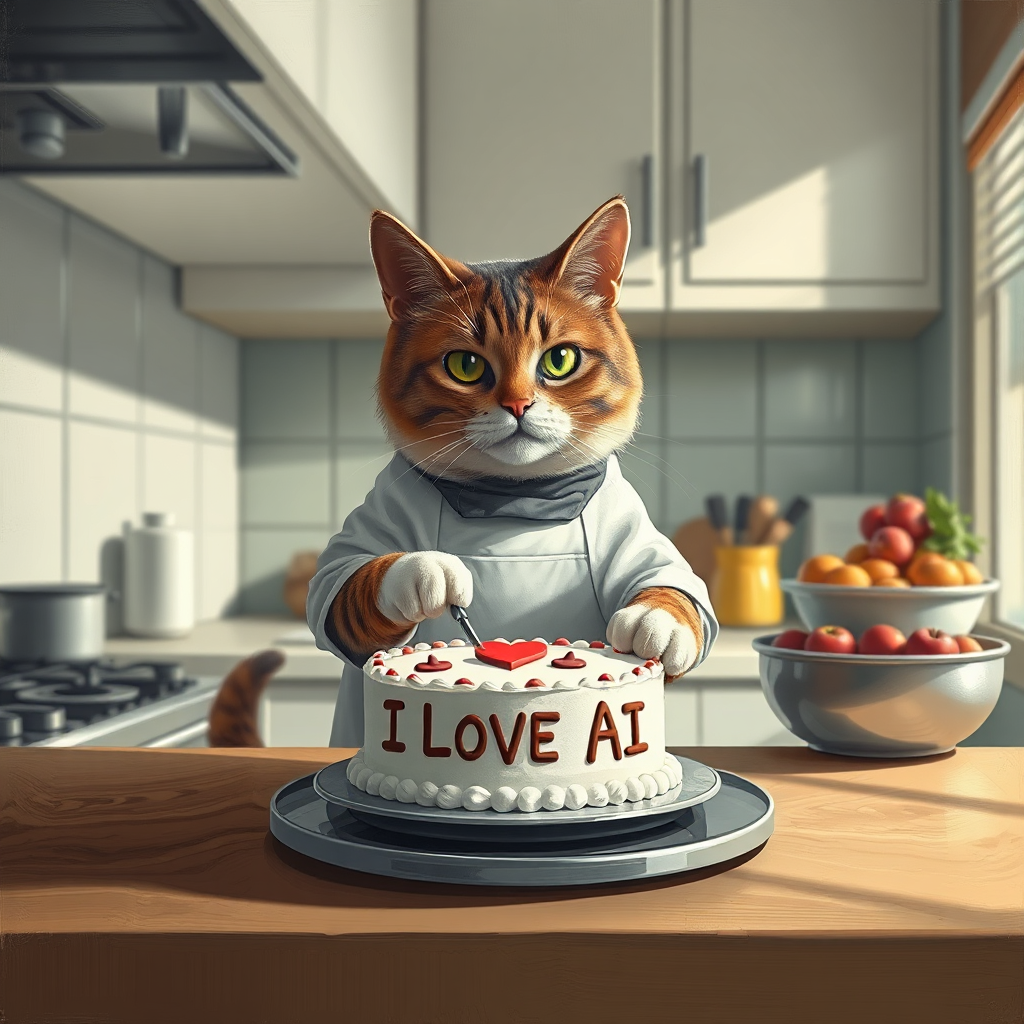

In [22]:
prompt = "a chef cat making a cake in the kitchen, the kitchen is modern and well-lit, the text on cake is saying 'I LOVE AI, the whole image is in oil paint style'"
image = pipe(
    prompt,
    negative_prompt="chef hat",
    guidance_scale=0.0,
    num_inference_steps=3,
    max_sequence_length=256,
    scale=3.5,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image

In [3]:
prompt = "a chef cat making a cake in the kitchen, the kitchen is modern and well-lit with the cake saying 'rm -rf /'"
image_normal = pipe(
    prompt,
    negative_prompt="chef hat",
    guidance_scale=0.0,
    num_inference_steps=8,
    max_sequence_length=256,
    scale=0,
    offset=torch.inf,
    generator=torch.Generator("cpu").manual_seed(19)
).images[0]

image_vsf = pipe(
    prompt,
    negative_prompt="chef hat",
    guidance_scale=0.0,
    num_inference_steps=8,
    max_sequence_length=256,
    scale=3.5,
    generator=torch.Generator("cpu").manual_seed(19)
).images[0]


torch.Size([1, 256, 4096]) torch.Size([256, 3]) torch.Size([1, 4, 4096]) torch.Size([4, 3])


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([1, 256, 4096]) torch.Size([256, 3]) torch.Size([1, 4, 4096]) torch.Size([4, 3])


  0%|          | 0/8 [00:00<?, ?it/s]